In [1]:
# Gun Violence Report App
# Adam Jones, 2020
# This application is designed to quickly calculate data regarding gun crime. All data used is
# from the Gun Violence Archive (https://www.gunviolencearchive.org/). The motivation behind 
# this app was to provide some personal practice in Python as well as understand patterns of
# gun violence in my hometown, NYC. Fortunately, the technologies used in this app can easily
# be modified for other uses. The core functionality of this app are to scrape a website, 
# navigate to a specific URL, generate and download a CSV for manipulation in Pandas. By 
# combining Selenium, BeautifulSoup, and CloudFlare Scraper, this task wasn't too difficult.


In [2]:
#Pandas, NumPY, Seaborn, and MatPlotLib
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display_html 


In [3]:
#Web Scraper Stuff 
import cfscrape as cloud
import re
import requests
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver import Firefox
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.keys import Keys
import os
import shutil

In [4]:
#Scraping and Souping 
baseurl = 'https://www.gunviolencearchive.org'
scraper = cloud.create_scraper()
site = scraper.get("https://www.gunviolencearchive.org/last-72-hours").content
soup = bs(site, 'html')

In [5]:
#Selecting the query(s) from the soup and concatenating to baseurl
link = soup.select("a[href*=export-csv]")
strlink =str(link)
oneofem=re.findall(r'"(.*?)"', strlink)
betterhalf=(oneofem[1])
fullurl = baseurl + betterhalf

In [6]:
#Settings for your headless browser (Firefox/Selenium)
opts = Options()
opts.headless = True
fp = webdriver.FirefoxProfile()
fp.set_preference('browser.download.folderList', 2)
fp.set_preference('browser.download.manager.showWhenStarting', False)
fp.set_preference('browser.download.dir', os.getcwd())
fp.set_preference('browser.helperApps.neverAsk.saveToDisk', 'application/vnd.ms-excel')




In [7]:
#Executing the query in browser and hunting for downloadable CSV element
driver = webdriver.Firefox(fp, options=opts)
driver.implicitly_wait(5)
driver.get(fullurl)
delay=5
dl = bs(driver.page_source, 'html')
dlstr = dl.select("a[href*=csv]")
print('The query is loading...')
while dlstr == []:
    dl = bs(driver.page_source, 'html')
    dlstr = dl.select("a[href*=csv]")
    x=0

element = driver.find_element_by_link_text("Download")

element.click()

#I can't speak too much to this code, got it from StackOverflow
#https://stackoverflow.com/questions/34548041/selenium-give-file-name-when-downloading

time_to_wait = 10
time_counter = 0
while not os.path.exists(os.getcwd()):
    time.sleep(1)
    time_counter += 1
    if time_counter > time_to_wait:break
Initial_path=os.getcwd()
filename = max([Initial_path + "/" + f for f in os.listdir(Initial_path)],key=os.path.getctime)
shutil.move(filename,os.path.join(Initial_path,r"data.csv"))
print(filename + ' has been downloaded and renamed to data.csv')
driver.quit()


The query is loading...
/Users/homefolder/GUN/awy5hi7l.csv.part has been downloaded and renamed to data.csv


In [8]:
#Importing CSV and fixing column names
bang = pd.read_csv('data.csv')
bang.columns = bang.columns.str.replace(' ', '_')
bang.columns = bang.columns.str.replace('#', 'no')
bang

,Incident_Date,State,City_Or_County,Address,no_Killed,no_Injured,Operations
0,"July 27, 2020",Illinois,Chicago,2000 block of E 66th St,0,1,NaN
1,"July 27, 2020",Illinois,Chicago,5100 block of S Michigan Ave,0,1,NaN
2,"July 27, 2020",Florida,Saint Petersburg,16th St S and 16th Ave S,0,1,NaN
3,"July 27, 2020",Maryland,Baltimore,3800 block of Fear Ave,0,2,NaN
4,"July 27, 2020",Pennsylvania,Pittsburgh,2700 block of Glen Mawr St,0,1,NaN
...,...,...,...,...,...,...,...
420,"July 24, 2020",Texas,Houston,6300 block of Windswept Ln,0,1,NaN
421,"July 24, 2020",South Carolina,Florence,Dixie St and Harrell St,0,0,NaN
422,"July 24, 2020",California,Bakersfield,S Union Ave and Wilson Rd,0,1,NaN
423,"July 24, 2020",California,El Monte,3400 block of Durfee Ave,1,0,NaN


In [9]:
df1=bang.groupby(['State']).sum().sort_values('no_Killed', ascending=False).drop(["Operations",'no_Injured'], axis=1).head(10)
df2=bang.groupby(['State']).sum().sort_values('no_Injured', ascending=False).drop(["Operations",'no_Killed'], axis=1).head(10)
df3=bang.groupby(['State']).count().sort_values('no_Injured', ascending=False).drop(['Operations', 'Address', 'no_Injured', 'no_Killed', 'City_Or_County'], axis=1).head(10)
df3.columns = ['no_Incidents']
df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Caption table 1')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Caption table 2')
df3_styler = df3.style.set_table_attributes("style='display:inline'").set_caption('Caption table 3')



In [10]:
#Top 10 States by Homicides + Top 10 States by Injuries (72 hour window)
display_html(df1_styler._repr_html_()+"\xa0\xa0\xa0"+df2_styler._repr_html_()+"\xa0\xa0\xa0" +df3_styler._repr_html_(), raw=True)

,no_Killed
State,
California,11
Texas,10
Florida,10
Illinois,9
Missouri,7
New York,7
Ohio,6
Kentucky,5
North Carolina,5


In [11]:
#Use iloc to choose state
bangny=bang.loc[bang['State'] == 'New York']

In [12]:
#Create array to include select city
fiveboros = ['New York (Manhattan)', 'Brooklyn', 'Bronx', 'Corona (Queens)', 'Staten Island']
metro = bangny['City_Or_County'].isin(fiveboros)


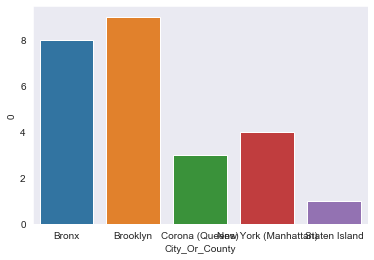

In [13]:
df5 = bangny[metro].groupby('City_Or_County', as_index=True).size()
df5.columns =[['City_Or_County','no_Incidents']]
df5=df5.to_frame()
sns.set_style("dark")
#bp1= sns.barplot(x=df5.index, y=0, data=df5)
bp1= df5.reset_index()

bp3= sns.barplot(x='City_Or_County', y=0, data=bp1)



In [14]:
Incident_Date= bangny[metro]['Incident_Date']
no_Injured= bangny[metro]['no_Injured']
no_Killed= bangny[metro]['no_Killed']

premelt = pd.DataFrame({
                   'Incident_Date': Incident_Date,
                   'no_Injured': no_Injured,
                   'no_Killed': no_Killed},
                    columns = ['Incident_Date','no_Injured','no_Killed'])

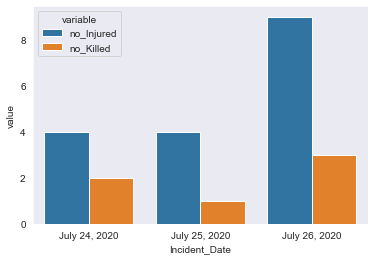

In [15]:
df4 = pd.melt(premelt, id_vars=['Incident_Date']).sort_values(['variable','value']).sort_values('Incident_Date')
df4= df4.groupby(['Incident_Date', 'variable']).sum()
bp= df4.reset_index()
#bp.info()
bp = sns.barplot(x='Incident_Date', y='value', hue='variable', data=bp)
